# Random forest classifier

In [39]:
import joblib
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
from scipy.stats import t as Student
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

from dataloaders import SKLMatchedPairsCGL
from evaluation import evaluate

## Unmatched halves without hyperparameter tuning

### Load data

In [2]:
data0_dir = Path('data/b_0_c_1_dT_01_t_1e03/')
data1_dir = Path('data/b_0_c_1_dT_01_t_1e04/')

data = SKLMatchedPairsCGL(data0_dir, data1_dir, train_match='unmatched_halves', seed=1234)

### Fit classifier

In [3]:
clf = RandomForestClassifier(random_state=data.rng.integers(data.seed))
clf.fit(data.X_train, data.y_train)

RandomForestClassifier(random_state=np.int64(421))

### Evaluate

In [4]:
predict = clf.predict(data.X_test)
eval_metrics = evaluate(predict, data.y_test)
print(eval_metrics)

{'accuracy': np.float64(0.9545), 'PPV': np.float64(0.9316239316239316), 'NPV': np.float64(0.9799366420274551), 'sensitivity': np.float64(0.981), 'specificity': np.float64(0.928), 'F-score': np.float64(0.9556746225036531)}


## Matched pairs without hyperparameter tuning

### Load data

In [5]:
data = SKLMatchedPairsCGL(data0_dir, data1_dir, train_match='half_matches', seed=1234)

### Fit classifier

In [6]:
clf = RandomForestClassifier(random_state=data.rng.integers(data.seed))
clf.fit(data.X_train, data.y_train)

RandomForestClassifier(random_state=np.int64(421))

### Evaluate

In [7]:
predict = clf.predict(data.X_test)
eval_metrics = evaluate(predict, data.y_test)
print(eval_metrics)

{'accuracy': np.float64(0.9535), 'PPV': np.float64(0.9314938154138915), 'NPV': np.float64(0.9778714436248683), 'sensitivity': np.float64(0.979), 'specificity': np.float64(0.928), 'F-score': np.float64(0.9546562652364702)}


## Find elbow forest size
Matched pairs no better than unmatched halves.
Use unmatched halves to minimize training time.

Training loss is 0 and test loss is very close to 0.
Performance far exceeds human.
No sign of overfitting, so do not prune tree.
Use elbow method to find ideal tree size.

In [8]:
data = SKLMatchedPairsCGL(data0_dir, data1_dir, train_match='unmatched_halves', seed=1234)

n_log2_forest_sizes = 10
n_forests = 10

all_accuracy = np.zeros((n_log2_forest_sizes, n_forests))
all_ppv = np.zeros((n_log2_forest_sizes, n_forests))
all_npv = np.zeros((n_log2_forest_sizes, n_forests))
all_sensitivity = np.zeros((n_log2_forest_sizes, n_forests))
all_specificity = np.zeros((n_log2_forest_sizes, n_forests))
all_f = np.zeros((n_log2_forest_sizes, n_forests))

for log2_forest_size in range(n_log2_forest_sizes):
    for random_state in tqdm(range(n_forests), desc='{} trees'.format(2**log2_forest_size)):
        clf = RandomForestClassifier(n_estimators=2**log2_forest_size,
                                     random_state=random_state)
        clf.fit(data.X_train, data.y_train)
        predict = clf.predict(data.X_dev)
        eval_metrics = evaluate(predict, data.y_dev)
        
        all_accuracy[log2_forest_size, random_state] = eval_metrics['accuracy']
        all_ppv[log2_forest_size, random_state] = eval_metrics['PPV']
        all_npv[log2_forest_size, random_state] = eval_metrics['NPV']
        all_sensitivity[log2_forest_size, random_state] = eval_metrics['sensitivity']
        all_specificity[log2_forest_size, random_state] = eval_metrics['specificity']
        all_f[log2_forest_size, random_state] = eval_metrics['F-score']

512 trees: 100%|██████████| 10/10 [12:58<00:00, 77.86s/it]


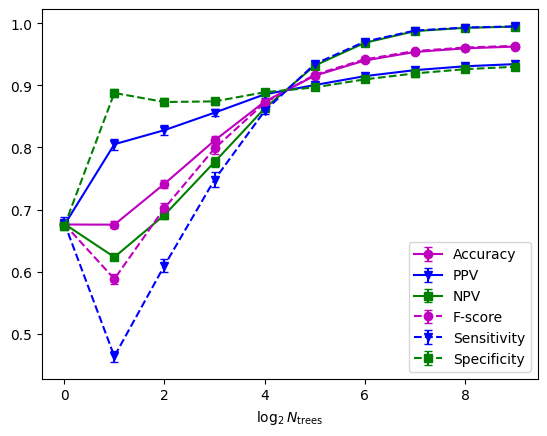

In [43]:
ci_ppf = Student.ppf(0.975, df=n_forests-1)

fig, ax = plt.subplots()
ax.errorbar(np.arange(n_log2_forest_sizes), np.mean(all_accuracy, axis=1),
            yerr=np.std(all_accuracy, axis=1)/np.sqrt(n_forests)*ci_ppf,
            capsize=3, color='m', marker='o', label='Accuracy')
ax.errorbar(np.arange(n_log2_forest_sizes), np.mean(all_ppv, axis=1),
            yerr=np.std(all_ppv, axis=1)/np.sqrt(n_forests)*ci_ppf,
            capsize=3, color='b', marker='v', label='PPV')
ax.errorbar(np.arange(n_log2_forest_sizes), np.mean(all_npv, axis=1),
            yerr=np.std(all_npv, axis=1)/np.sqrt(n_forests)*ci_ppf,
            capsize=3, color='g', marker='s', label='NPV')
ax.errorbar(np.arange(n_log2_forest_sizes), np.mean(all_f, axis=1),
            yerr=np.std(all_f, axis=1)/np.sqrt(n_forests)*ci_ppf,
            capsize=3, color='m', marker='o', ls='--', mfc=None, label='F-score')
ax.errorbar(np.arange(n_log2_forest_sizes), np.mean(all_sensitivity, axis=1),
            yerr=np.std(all_sensitivity, axis=1)/np.sqrt(n_forests)*ci_ppf,
            capsize=3, color='b', marker='v', ls='--', mfc=None, label='Sensitivity')
ax.errorbar(np.arange(n_log2_forest_sizes), np.mean(all_specificity, axis=1),
            yerr=np.std(all_specificity, axis=1)/np.sqrt(n_forests)*ci_ppf,
            capsize=3, color='g', marker='s', ls='--', mfc=None, label='Specificity')
ax.legend()
ax.set_xlabel(r'$\log_2 N_\text{trees}$')
plt.savefig('figures/random_forest_metrics.pdf', bbox_inches='tight')

## Train final model and interpret
Evaluation set metrics plateau around 128 trees.
Train final model with 128 trees and interpret features.

In [41]:
clf = RandomForestClassifier(n_estimators=128, random_state=data.rng.integers(data.seed))
clf.fit(data.X_train, data.y_train)
joblib.dump(clf, 'models/random_forest.joblib') # save model

['models/random_forest.joblib']

In [49]:
importances = clf.feature_importances_.reshape((2, 32, 32))

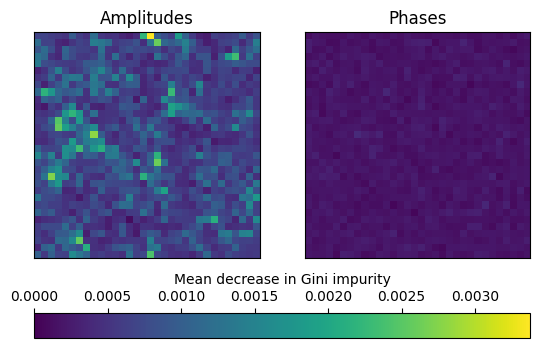

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2)

vmin = 0.0
vmax = importances.max()

im1 = ax1.imshow(importances[0], vmin=vmin, vmax=vmax)
ax2.imshow(importances[1], vmin=vmin, vmax=vmax)

ax1.set_xticks([])
ax2.set_xticks([])
ax1.set_yticks([])
ax2.set_yticks([])

ax1.set_title('Amplitudes')
ax2.set_title('Phases')

cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label("Mean decrease in Gini impurity")

plt.savefig('figures/random_forest_importances.pdf', bbox_inches='tight')